

# Item based filtering
This approach is mostly preferred since the movie don't change much. We can rerun this model once a week unlike User based where we have to frequently run the model.

In this kernel, We look at the implementation of Item based filtering

### https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/

In [20]:
import pandas as pd
import numpy as np
import json

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv("../data/movies.csv",encoding='latin-1')
ratings = pd.read_csv("../data/ratings.csv",encoding='latin-1')

In [21]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


Ratings dataset has 
* userId - unique for each user
* movieId - using this feature ,we take the title of the movie from movies dataset
* rating - Ratings given by each user to all the movies using this we are going to predict the top 10 similar movies

In [22]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Movie dataset has 
* movieId - once the recommendation is done, we get list of all similar movieId and get the title for each movie from this dataset. 
* genres -  which is not required for this filtering approach

In [23]:
final_dataset = ratings.pivot(index='movieId',columns='userId',values='rating')
final_dataset.head()

userId,316,320,359,370,910,975,1015,1387,1447,1588,...,137118,137209,137227,137446,137559,137609,137805,138072,138176,138200
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,NaN,5.0,4.5,5.0,NaN,4.0,3.0,4.5,4.5,...,3.0,NaN,NaN,NaN,3.5,NaN,4.0,3.0,NaN,3.0
2,NaN,NaN,NaN,4.0,4.0,NaN,3.0,3.0,NaN,NaN,...,NaN,3.5,NaN,3.5,NaN,NaN,2.0,1.0,NaN,NaN
3,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,3.5,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
final_dataset.fillna(0,inplace=True)
final_dataset.head()

userId,316,320,359,370,910,975,1015,1387,1447,1588,...,137118,137209,137227,137446,137559,137609,137805,138072,138176,138200
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,0.0,5.0,4.5,5.0,0.0,4.0,3.0,4.5,4.5,...,3.0,0.0,0.0,0.0,3.5,0.0,4.0,3.0,0.0,3.0
2,0.0,0.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,0.0,...,0.0,3.5,0.0,3.5,0.0,0.0,2.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In a real world, ratings are very sparse and data points are mostly collected from very popular movies and highly engaged users. So we will reduce the noise by adding some filters and qualify the movies for the final dataset.
* To qualify a movie, minimum 10 users should have voted a movie.
* To qualify a user, minimum 50 movies should have voted by the user.


In [25]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

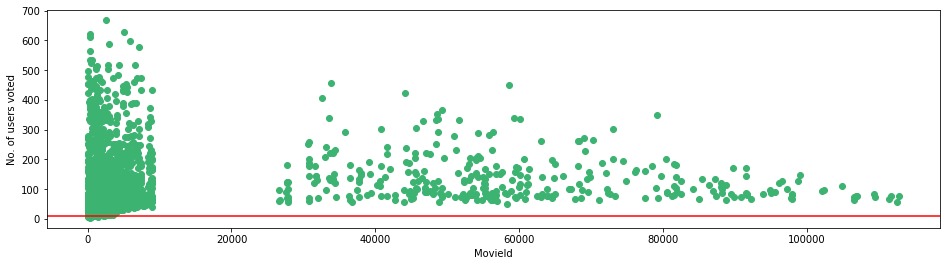

In [26]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [27]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index,:]

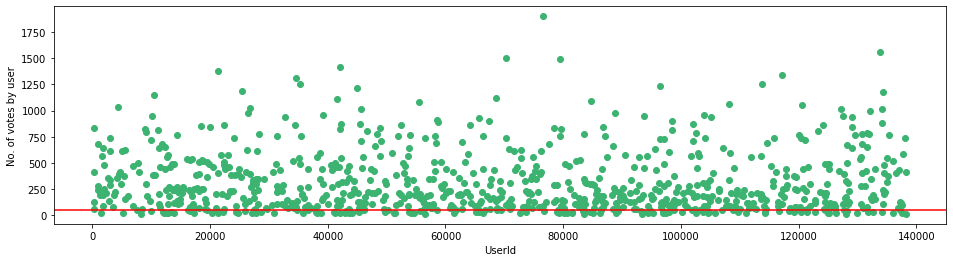

In [28]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [29]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
final_dataset

userId,316,320,359,370,910,975,1015,1387,1588,1738,...,136455,136856,137118,137209,137227,137446,137559,137805,138072,138200
movieId,,,,,,,,,,,,,,,,,,,,,
1,2.5,0.0,5.0,4.5,5.0,0.0,4.0,3.0,4.5,0.0,...,3.0,0.0,3.0,0.0,0.0,0.0,3.5,4.0,3.0,3.0
2,0.0,0.0,0.0,4.0,4.0,0.0,3.0,3.0,0.0,0.0,...,3.5,0.0,0.0,3.5,0.0,3.5,0.0,2.0,1.0,0.0
3,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,3.5,0.0,3.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109487,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111362,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
111759,0.0,0.0,0.0,4.5,4.5,3.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our final_dataset has dimensions of **2121 * 378** where most of the values are sparse. I took only small dataset but for
original large dataset of movie lens which has more than **100000** features, this will sure hang our system when this has 
feed to model. To reduce the sparsity we use csr_matric scipy lib. I'll give an example how it works

In [30]:
sample = np.array([[0,0,3,0,0],[4,0,0,0,2],[0,0,0,0,1]])
sparsity = 1.0 - ( np.count_nonzero(sample) / float(sample.size) )
print(sparsity)

0.7333333333333334


In [31]:
csr_sample = csr_matrix(sample)
print(csr_sample)

  (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1


* As you can see there is no sparse value in the csr_sample and values are assigned as rows and column index. for the 0th row and 2nd column , value is 3 . Look at the original dataset where the values at the right place. This is how it works using todense method you can take it back to original dataset.
* Most of the sklearn works with sparse matrix. surely this will improve our performance

In [32]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

We use cosine distance metric which is very fast and preferable than pearson coefficient. Please don't use euclidean distance which will not work when the values are equidistant.

In [34]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [35]:
def get_movie_recommendation(movie_name):
    n_movies_to_reccomend = 10
    movie_list = movies[movies['title'].str.contains(movie_name)]  
    if len(movie_list):        
        movie_idx= movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Genre':movies.iloc[idx]['genres'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))


        #(index|columns|records|split|table)
        js = df.to_json(orient='index')

        final_list = list()
        for row in df.iterrows():
            final_list.append(row[1].to_dict())
        
        with open('json_data/data.json', 'w') as f:
            f.write(json.dumps(final_list, indent=4))

        # with open('json_data/data.json', 'w', encoding='utf-8') as f:
        #     json.dump(js, f, ensure_ascii=False, indent=4)
        print(json.dumps(final_list, indent=4))
        return df
    
    else:
        return "No movies found. Please check your input"

In [36]:
get_movie_recommendation('Goodfellas')

[
    {
        "Title": "Departed, The (2006)",
        "Genre": "Crime|Drama|Thriller",
        "Distance": 0.34705902842222613
    },
    {
        "Title": "Seven (a.k.a. Se7en) (1995)",
        "Genre": "Mystery|Thriller",
        "Distance": 0.33550617177033504
    },
    {
        "Title": "Fargo (1996)",
        "Genre": "Comedy|Crime|Drama|Thriller",
        "Distance": 0.3310207119537921
    },
    {
        "Title": "Shawshank Redemption, The (1994)",
        "Genre": "Crime|Drama",
        "Distance": 0.323174212764624
    },
    {
        "Title": "Usual Suspects, The (1995)",
        "Genre": "Crime|Mystery|Thriller",
        "Distance": 0.32168668014072466
    },
    {
        "Title": "Reservoir Dogs (1992)",
        "Genre": "Crime|Mystery|Thriller",
        "Distance": 0.31654211099381235
    },
    {
        "Title": "Silence of the Lambs, The (1991)",
        "Genre": "Crime|Horror|Thriller",
        "Distance": 0.3164233524430121
    },
    {
        "Title": "Godf

,Title,Genre,Distance
1,"Departed, The (2006)",Crime|Drama|Thriller,0.347059
2,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0.335506
3,Fargo (1996),Comedy|Crime|Drama|Thriller,0.331021
4,"Shawshank Redemption, The (1994)",Crime|Drama,0.323174
5,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0.321687
6,Reservoir Dogs (1992),Crime|Mystery|Thriller,0.316542
7,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,0.316423
8,"Godfather: Part II, The (1974)",Crime|Drama,0.316339
9,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,0.279953
10,"Godfather, The (1972)",Crime|Drama,0.270401


Our model works perfectly predicting the recommendation based on user behaviour and past search. So we conclude our 
collaborative filtering here.
